In [69]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import time
import pickle
import matplotlib.pyplot as plt
import datetime

In [39]:
# Load data from pkl file
df = pd.read_csv('payments.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values(by=['datetime'], inplace=True)
df['date'] = df['datetime'].dt.date

In [40]:
# Q.1: Extract the number of participants active in the whole file
print('number of active participants:', 
      len(np.unique([df.sender, df.receiver])))
np.unique([df.sender, df.receiver])

number of active participants: 20


array(['participant-1', 'participant-10', 'participant-11',
       'participant-12', 'participant-13', 'participant-14',
       'participant-15', 'participant-16', 'participant-17',
       'participant-18', 'participant-19', 'participant-2',
       'participant-20', 'participant-3', 'participant-4',
       'participant-5', 'participant-6', 'participant-7', 'participant-8',
       'participant-9'], dtype=object)

In [41]:
# Q.2: Extract the number of days
print('number of days:', len(df['datetime'].dt.date.unique()))
df['datetime'].dt.date.unique()

number of days: 10


array([datetime.date(2022, 10, 18), datetime.date(2022, 10, 19),
       datetime.date(2022, 10, 20), datetime.date(2022, 10, 21),
       datetime.date(2022, 10, 22), datetime.date(2022, 10, 23),
       datetime.date(2022, 10, 24), datetime.date(2022, 10, 25),
       datetime.date(2022, 10, 26), datetime.date(2022, 10, 27)],
      dtype=object)

In [42]:
# Q.3: Extract the overall mean payment value
print('Mean Payment Value (£):', f"{(df['value'].mean()):,.2f}")

Mean Payment Value (£): 6,057,654.15


In [43]:
# Q.4: Extract the overall mean daily volume
print('Mean Daily Volume:', f"{(df.groupby('date').size().mean()):,.2f}")
df.groupby('date').size()

Mean Daily Volume: 24,210.30


date
2022-10-18    21558
2022-10-19    36333
2022-10-20    18247
2022-10-21    25380
2022-10-22    25356
2022-10-23    26932
2022-10-24    27375
2022-10-25    18978
2022-10-26    17779
2022-10-27    24165
dtype: int64

In [44]:
# Q.5: Extract the total value to be cleared for each day
print('Total values to be cleared:')
df.groupby('date')['value'].sum()

Total values to be cleared:


date
2022-10-18    1.299520e+11
2022-10-19    2.211221e+11
2022-10-20    1.094795e+11
2022-10-21    1.530781e+11
2022-10-22    1.549165e+11
2022-10-23    1.636263e+11
2022-10-24    1.663443e+11
2022-10-25    1.138408e+11
2022-10-26    1.074475e+11
2022-10-27    1.467692e+11
Name: value, dtype: float64

In [45]:
# Q.6: Extract the LNNCP of each participant and the system-level LNNCP for each day
def lnncp_function(daily_payments):
    
    # get unique members
    members = np.unique([daily_payments.sender, daily_payments.receiver])
        
    lnncp_dict = {}
    
    # for each members
    for member in members:
        
        # get their payments sent and received
        df_payments = daily_payments.loc[(daily_payments.sender == member)|
                                         (daily_payments.receiver == member)]
                
        # if no payments, then set their LNNCP to 0
        if df_payments.shape[0] == 0:
            lnncp_dict[member] = daily_payments.datetime.iloc[0].replace(
                hour = 0, minute = 0, second = 0), 0, 0
            continue
    
        # set sent payments as negative
        to_cumulate = df_payments.apply(lambda x: x.value*(-1) 
                                        if x.sender == member 
                                        else x.value, axis=1)
        
        # do the cumulative sum of payments sent and received (this gives the balance at each row)
        liquidity_series = to_cumulate.cumsum().set_axis(df_payments.datetime)
        
        # get the min of the balance (= LNNCP)
        lnncp_value = liquidity_series.min()
        lnncp_value = min(lnncp_value, 0.0)
        
        # get the time at which the minimum was reached
        min_datetime = to_cumulate.cumsum().set_axis(df_payments.datetime).idxmin()
        
        # get the total value to be cleared
        gross_cleared = daily_payments.loc[(daily_payments.sender == member)].value.sum()
        
        lnncp_dict[member] = min_datetime, lnncp_value, gross_cleared
    
    lnncp_df = pd.DataFrame.from_dict(lnncp_dict, orient='index', columns=['datetime','lnncp','value_cleared'])   
    return lnncp_df

In [46]:
start_time = time.time()

l_lnncp_df = list()
l_system_lnncp = list()
l_system_value = list()

# for each day
for date in np.unique(df['date']):
    
    tmp = df[df['date']==date]
    
    # get the LNNCP of each participant
    lnncp_tmp = lnncp_function(tmp)
    l_lnncp_df.append(lnncp_tmp.reset_index())
    
    # save the system level LNNCP
    l_system_lnncp.append(lnncp_tmp['lnncp'].sum())
    
    # save the system level gross value to be cleared
    l_system_value.append(lnncp_tmp['value_cleared'].sum())

# concatenate the participant level dfs
lnncp_df = pd.concat(l_lnncp_df, ignore_index=True)

# create a system level df from the lists
system_df = pd.DataFrame.from_dict({'date': np.unique(df['date']), 
                                    'lnncp': l_system_lnncp,
                                    'value_cleared':l_system_value})

print('execution time:', float(time.time() - start_time))

execution time: 7.110455274581909


In [47]:
lnncp_df

,index,datetime,lnncp,value_cleared
0,participant-1,2022-10-18 17:59:57.754591151,-2.859489e+09,1.929778e+10
1,participant-10,2022-10-18 17:55:24.179068273,-4.949653e+07,2.918463e+08
2,participant-11,2022-10-18 17:59:10.974717317,-1.109891e+08,2.911659e+08
3,participant-12,2022-10-18 10:27:43.575289499,-4.153916e+06,1.186346e+08
4,participant-13,2022-10-18 16:00:23.731664123,-3.114728e+07,1.284523e+08
...,...,...,...,...
195,participant-5,2022-10-27 17:50:22.627724349,-2.094781e+08,5.962960e+08
196,participant-6,2022-10-27 09:02:04.171608622,-5.440078e+07,2.591723e+10
197,participant-7,2022-10-27 09:00:05.044906500,-3.943330e+06,2.520631e+10
198,participant-8,2022-10-27 09:00:50.760944692,-6.514007e+07,2.597309e+10


In [48]:
system_df

,date,lnncp,value_cleared
0,2022-10-18,-9.573047e+09,1.299520e+11
1,2022-10-19,-1.627802e+10,2.211221e+11
2,2022-10-20,-8.319892e+09,1.094795e+11
3,2022-10-21,-1.116412e+10,1.530781e+11
4,2022-10-22,-1.120268e+10,1.549165e+11
5,2022-10-23,-1.191097e+10,1.636263e+11
6,2022-10-24,-1.222198e+10,1.663443e+11
7,2022-10-25,-8.629770e+09,1.138408e+11
8,2022-10-26,-7.209976e+09,1.074475e+11
9,2022-10-27,-9.668970e+09,1.467692e+11


In [49]:
# Q.7: Divide the system LNNCP by the total value cleared for each day. What is the interpretation of this measure?

In [50]:
lnncp_df['efficiency'] = -lnncp_df['lnncp'] / lnncp_df['value_cleared']
system_df['efficiency'] = -system_df['lnncp'] / system_df['value_cleared']

In [51]:
lnncp_df.head(20)

,index,datetime,lnncp,value_cleared,efficiency
0,participant-1,2022-10-18 17:59:57.754591151,-2.859489e+09,1.929778e+10,0.148177
1,participant-10,2022-10-18 17:55:24.179068273,-4.949653e+07,2.918463e+08,0.169598
2,participant-11,2022-10-18 17:59:10.974717317,-1.109891e+08,2.911659e+08,0.381189
3,participant-12,2022-10-18 10:27:43.575289499,-4.153916e+06,1.186346e+08,0.035014
4,participant-13,2022-10-18 16:00:23.731664123,-3.114728e+07,1.284523e+08,0.242481
5,participant-14,2022-10-18 17:20:08.063303810,-3.800291e+07,1.216511e+08,0.312393
6,participant-15,2022-10-18 16:57:57.806212177,-6.695540e+07,1.184878e+08,0.565083
7,participant-16,2022-10-18 15:16:45.379009518,-5.439684e+07,1.020293e+08,0.533149
8,participant-17,2022-10-18 17:29:38.506828078,-6.312856e+07,1.072934e+08,0.588373
9,participant-18,2022-10-18 17:20:44.044956996,-5.358148e+07,9.307069e+07,0.575707


In [52]:
system_df

,date,lnncp,value_cleared,efficiency
0,2022-10-18,-9.573047e+09,1.299520e+11,0.073666
1,2022-10-19,-1.627802e+10,2.211221e+11,0.073616
2,2022-10-20,-8.319892e+09,1.094795e+11,0.075995
3,2022-10-21,-1.116412e+10,1.530781e+11,0.072931
4,2022-10-22,-1.120268e+10,1.549165e+11,0.072314
5,2022-10-23,-1.191097e+10,1.636263e+11,0.072794
6,2022-10-24,-1.222198e+10,1.663443e+11,0.073474
7,2022-10-25,-8.629770e+09,1.138408e+11,0.075806
8,2022-10-26,-7.209976e+09,1.074475e+11,0.067102
9,2022-10-27,-9.668970e+09,1.467692e+11,0.065879


It is a measure of efficiency.

Participants only need to provide ~7% of the total value cleared as liquidity (at the system level).

In [53]:
# Q.8: What is the participant best efficiency on average? With the worst?
lnncp_df.groupby(['index']).mean().sort_values('efficiency')

,datetime,lnncp,value_cleared,efficiency
index,,,,
participant-7,2022-10-22 21:06:20.036141056,-4.770263e+07,2.540784e+10,0.001747
participant-6,2022-10-22 21:02:42.420546304,-4.527782e+07,2.503242e+10,0.001998
participant-8,2022-10-22 21:07:26.837614336,-9.116543e+07,2.543078e+10,0.004018
participant-2,2022-10-23 05:57:21.712354560,-2.783194e+09,2.172789e+10,0.125932
participant-1,2022-10-23 05:57:59.750478336,-3.144422e+09,2.236091e+10,0.139736
participant-3,2022-10-23 05:58:46.664104448,-3.240714e+09,2.258722e+10,0.143312
participant-4,2022-10-23 05:02:56.368157184,-2.571819e+08,1.420617e+09,0.179821
participant-5,2022-10-23 04:29:50.248661504,-1.693665e+08,6.658125e+08,0.259650
participant-10,2022-10-23 04:13:40.725989376,-8.030682e+07,3.022763e+08,0.260639


In [54]:
lnncp_df

,index,datetime,lnncp,value_cleared,efficiency
0,participant-1,2022-10-18 17:59:57.754591151,-2.859489e+09,1.929778e+10,0.148177
1,participant-10,2022-10-18 17:55:24.179068273,-4.949653e+07,2.918463e+08,0.169598
2,participant-11,2022-10-18 17:59:10.974717317,-1.109891e+08,2.911659e+08,0.381189
3,participant-12,2022-10-18 10:27:43.575289499,-4.153916e+06,1.186346e+08,0.035014
4,participant-13,2022-10-18 16:00:23.731664123,-3.114728e+07,1.284523e+08,0.242481
...,...,...,...,...,...
195,participant-5,2022-10-27 17:50:22.627724349,-2.094781e+08,5.962960e+08,0.351299
196,participant-6,2022-10-27 09:02:04.171608622,-5.440078e+07,2.591723e+10,0.002099
197,participant-7,2022-10-27 09:00:05.044906500,-3.943330e+06,2.520631e+10,0.000156
198,participant-8,2022-10-27 09:00:50.760944692,-6.514007e+07,2.597309e+10,0.002508


The participant with the best efficiency on average is participant-7.

The participant with the worst efficiency on average is participant-20.

In [55]:
# Q.9: Which hour of the day has the highest number of payments on average? What is the proportion of daily payments happening 
# during this hour?

In [56]:
df.set_index('datetime', inplace=True)

In [57]:
tmp = df.resample('1H')['value'].size().to_frame().reset_index()
tmp['hour'] = tmp['datetime'].dt.time
tmp

,datetime,value,hour
0,2022-10-18 09:00:00,4311,09:00:00
1,2022-10-18 10:00:00,2156,10:00:00
2,2022-10-18 11:00:00,2156,11:00:00
3,2022-10-18 12:00:00,1078,12:00:00
4,2022-10-18 13:00:00,1078,13:00:00
...,...,...,...
220,2022-10-27 13:00:00,1208,13:00:00
221,2022-10-27 14:00:00,2819,14:00:00
222,2022-10-27 15:00:00,2819,15:00:00
223,2022-10-27 16:00:00,2819,16:00:00


In [58]:
result_df = tmp.groupby('hour')['value'].mean().to_frame().reset_index()
result_df[result_df['value']>0].sort_values('value', ascending=False)

,hour,value
9,09:00:00,4841.8
17,17:00:00,3631.6
14,14:00:00,2824.5
15,15:00:00,2824.5
16,16:00:00,2824.5
10,10:00:00,2421.1
11,11:00:00,2421.1
12,12:00:00,1210.6
13,13:00:00,1210.6


In [59]:
df = pd.read_csv('payments.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values(by=['datetime'], inplace=True)
df['date'] = df['datetime'].dt.date

In [60]:
# Creating links with the attributes of interest
value_df = df.groupby(['date','sender','receiver'])['value'].sum().to_frame().reset_index()
volume_df = df.groupby(['date','sender','receiver'])['value'].size().to_frame().reset_index()
volume_df.rename(columns={'value':'volume'}, inplace=True)

links_df = pd.merge(value_df, volume_df, how='outer', on=['date','sender','receiver'])

# creating a dict containing a directed graph for each date
# format: dict_graphs = {date: nx.DiGraph}
dict_graphs = dict()

# for each day
for date in np.unique(links_df['date']):
    # initialize the graph
    dict_graphs[date] = nx.DiGraph()
    
    # add links with the right attributes to the DiGraph
    tmp = links_df[links_df['date']==date].copy()
    tmp.drop(['date'], axis=1, inplace=True)
    tmp.rename(columns={'sender':'source', 'receiver':'target'}, inplace=True)
    dict_graphs[date] = nx.from_pandas_edgelist(tmp, edge_attr=True, create_using=nx.DiGraph())

In [61]:
print('All links of Participant 1 on', date, '\n')
for receiver in dict_graphs[date]['participant-1']:
    print(receiver, dict_graphs[date]['participant-1'][receiver])

All links of Participant 1 on 2022-10-27 

participant-10 {'value': 40119654.78256494, 'volume': 10}
participant-11 {'value': 32871128.728441626, 'volume': 8}
participant-12 {'value': 15412023.574811675, 'volume': 4}
participant-13 {'value': 24643949.25471225, 'volume': 6}
participant-14 {'value': 33299865.81426376, 'volume': 8}
participant-15 {'value': 3774623.434536593, 'volume': 1}
participant-16 {'value': 21368818.75336948, 'volume': 5}
participant-17 {'value': 5271156.366039251, 'volume': 1}
participant-18 {'value': 3836510.102710253, 'volume': 1}
participant-19 {'value': 6246854.389614948, 'volume': 1}
participant-2 {'value': 2922696095.8106737, 'volume': 708}
participant-20 {'value': 6443299.749280172, 'volume': 1}
participant-3 {'value': 2929389271.55835, 'volume': 719}
participant-4 {'value': 153263599.0656294, 'volume': 38}
participant-5 {'value': 57531758.22562255, 'volume': 14}
participant-6 {'value': 5141258350.890289, 'volume': 752}
participant-7 {'value': 5242983136.0331

In [62]:
# Computing nodes attributes
links_df.groupby(['date','sender'])['value'].sum().to_frame().reset_index()

# Computing daily value to be cleared
value_sent_df = links_df.groupby(['date','sender'])['value'].sum().to_frame().reset_index()

# Computing daily volume to be cleared
volume_sent_df = links_df.groupby(['date','sender'])['value'].size().to_frame().reset_index()
volume_sent_df.rename(columns={'value':'volume'}, inplace=True)

# merging the above into a single nodes_df
nodes_df = pd.merge(value_sent_df, volume_sent_df, how='outer', on=['date','sender'])

# renaming the participant column
nodes_df.rename(columns={'sender':'participant'}, inplace=True)
nodes_df.head()

,date,participant,value,volume
0,2022-10-18,participant-1,1.929778e+10,19
1,2022-10-18,participant-10,2.918463e+08,7
2,2022-10-18,participant-11,2.911659e+08,7
3,2022-10-18,participant-12,1.186346e+08,6
4,2022-10-18,participant-13,1.284523e+08,8


In [63]:
# Computing LNNCP and efficiency for each node on each day
l_lnncp_df = list()

# for each day
for date in np.unique(df['date']):
    
    tmp = df[df['date']==date]
    
    # get the LNNCP of each participant
    lnncp_tmp = lnncp_function(tmp)
    l_lnncp_df.append(lnncp_tmp.reset_index())

# concatenate the participant level dfs
lnncp_df = pd.concat(l_lnncp_df, ignore_index=True)

In [64]:
# adding the efficiency column
lnncp_df['efficiency'] = -lnncp_df['lnncp'] / lnncp_df['value_cleared']

# changing sign of the LNNCP
lnncp_df['lnncp'] = -lnncp_df['lnncp']

# extracting date out of datetime
lnncp_df['date'] = lnncp_df['datetime'].dt.date

# dropping two columns
lnncp_df.drop(['datetime', 'value_cleared'], axis=1, inplace=True)

# renaming the participant column
lnncp_df.rename(columns={'index':'participant'}, inplace=True)
lnncp_df.head()

,participant,lnncp,efficiency,date
0,participant-1,2.859489e+09,0.148177,2022-10-18
1,participant-10,4.949653e+07,0.169598,2022-10-18
2,participant-11,1.109891e+08,0.381189,2022-10-18
3,participant-12,4.153916e+06,0.035014,2022-10-18
4,participant-13,3.114728e+07,0.242481,2022-10-18


In [65]:
# merging nodes_df with lnncp_df
nodes_df = pd.merge(nodes_df, lnncp_df, how='outer', on=['date','participant'])
nodes_df.head()

,date,participant,value,volume,lnncp,efficiency
0,2022-10-18,participant-1,1.929778e+10,19,2.859489e+09,0.148177
1,2022-10-18,participant-10,2.918463e+08,7,4.949653e+07,0.169598
2,2022-10-18,participant-11,2.911659e+08,7,1.109891e+08,0.381189
3,2022-10-18,participant-12,1.186346e+08,6,4.153916e+06,0.035014
4,2022-10-18,participant-13,1.284523e+08,8,3.114728e+07,0.242481


In [66]:
# add attributes to the networks
# format of the command: nx.set_node_attributes(G, {node: value}, name="attribute")

for index, row in nodes_df.iterrows():
    for attr in ['value', 'volume', 'lnncp', 'efficiency']:
        nx.set_node_attributes(dict_graphs[row['date']], {row['participant']: row[attr]}, name=attr)
        
print('All attributes of Participant 1 on', date, '\n')
for attr in dict_graphs[date].nodes['participant-1']:
    print(attr, dict_graphs[date].nodes['participant-1'][attr])

All attributes of Participant 1 on 2022-10-27 

value 21999700977.78923
volume 19
lnncp 2137015040.000973
efficiency 0.09713836756956337


In [67]:
# saving the links and nodes attributes in csv files
links_df.to_csv('links.csv', index=False)
nodes_df.to_csv('nodes.csv', index=False)
# saving the dictionary of networks in a pkl file
with open('networks.pkl', 'wb') as handle:
    pickle.dump(dict_graphs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
with open('networks.pkl', 'rb') as handle:
    dict_graphs = pickle.load(handle)
date = datetime.date(2022, 10, 27)
G = dict_graphs[date]

In [71]:
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Maximum number of edges:', 20*19)
print('Density:', nx.density(G), '|| Formula:', '('+str(200)+'/'+str(380)+')')

Number of nodes: 20
Number of edges: 200
Maximum number of edges: 380
Density: 0.5263157894736842 || Formula: (200/380)


In [72]:
# Compute and print the adjacency matrix of the network with volume weights
nx.adjacency_matrix(G)

<20x20 sparse array of type '<class 'numpy.intc'>'
	with 200 stored elements in Compressed Sparse Row format>

In [73]:
print(nx.adjacency_matrix(G, weight='volume').toarray())

[[  0  10   8   4   6   8   1   5   1   1   1 708   1 719  38  14 752 773
  784  14]
 [  5   0   0   1   0   0   0   0   1   0   0   7   0  12   1   0  11   6
   11   0]
 [ 12   0   0   0   0   0   0   0   0   0   0   8   0   8   1   0   4   5
   11   1]
 [  5   0   0   0   0   0   0   0   0   0   0   9   0   3   0   0   8   3
    8   0]
 [  7   0   0   0   0   0   0   0   0   0   0   3   0   4   0   0   6   4
    5   0]
 [  7   0   0   0   0   0   0   0   0   0   0   4   0   4   0   0   3   6
    2   0]
 [  4   0   0   1   0   0   0   0   0   0   0   5   0   3   1   0   2   6
    3   0]
 [  7   0   0   0   0   0   0   0   0   0   0   1   0   1   0   0   1   3
    1   0]
 [  2   0   0   0   0   0   0   0   0   0   0   2   0   6   0   0   1   1
    4   0]
 [  3   0   0   0   0   0   0   0   0   0   0   3   0   5   0   0   3   4
    3   0]
 [  1   0   0   0   0   0   0   0   0   0   0   4   0   2   0   0   2   2
    3   0]
 [759   7   9   0   2   2   0   0   0   0   1   0   1 737  48  18

In [74]:
# Is the network fully connected? Determine if the network is strongly connected or weekly connected
for cc in nx.strongly_connected_components(G):
    print(cc)
    print('size of the giant component:', len(cc))

{'participant-13', 'participant-20', 'participant-5', 'participant-7', 'participant-15', 'participant-18', 'participant-11', 'participant-10', 'participant-8', 'participant-9', 'participant-1', 'participant-19', 'participant-14', 'participant-3', 'participant-16', 'participant-12', 'participant-6', 'participant-2', 'participant-4', 'participant-17'}
size of the giant component: 20


Average shortest path length: 1.4736842105263157


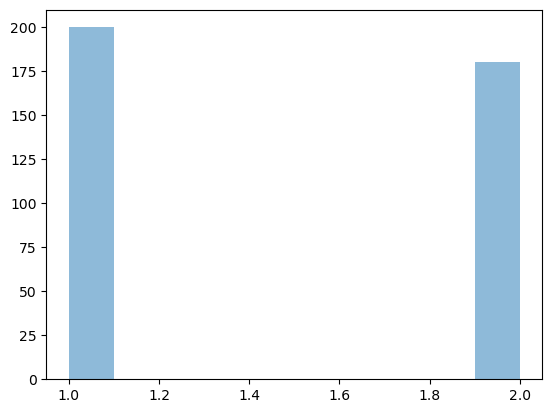

In [75]:
# Plot the distribution of shortest path lengths. What is the average shortest path length?
distribution = list()
lengths = nx.all_pairs_shortest_path_length(G)
for row in lengths:
    for k, v in row[1].items():
        if v != 0:
            distribution.append(v)
print('Average shortest path length:', np.mean(distribution))
plt.hist(distribution, alpha=0.5)
plt.show()

In [76]:
print('Network diameter:', nx.diameter(G))
print('Average clustering coefficient:', nx.average_clustering(G))
print('Edge from participant-6 to participant-8:', G['participant-6']['participant-8'])

Network diameter: 2
Average clustering coefficient: 0.8362917667253484
Edge from participant-6 to participant-8: {'value': 6320169336.181229, 'volume': 772}


20.0
10.0
10.0


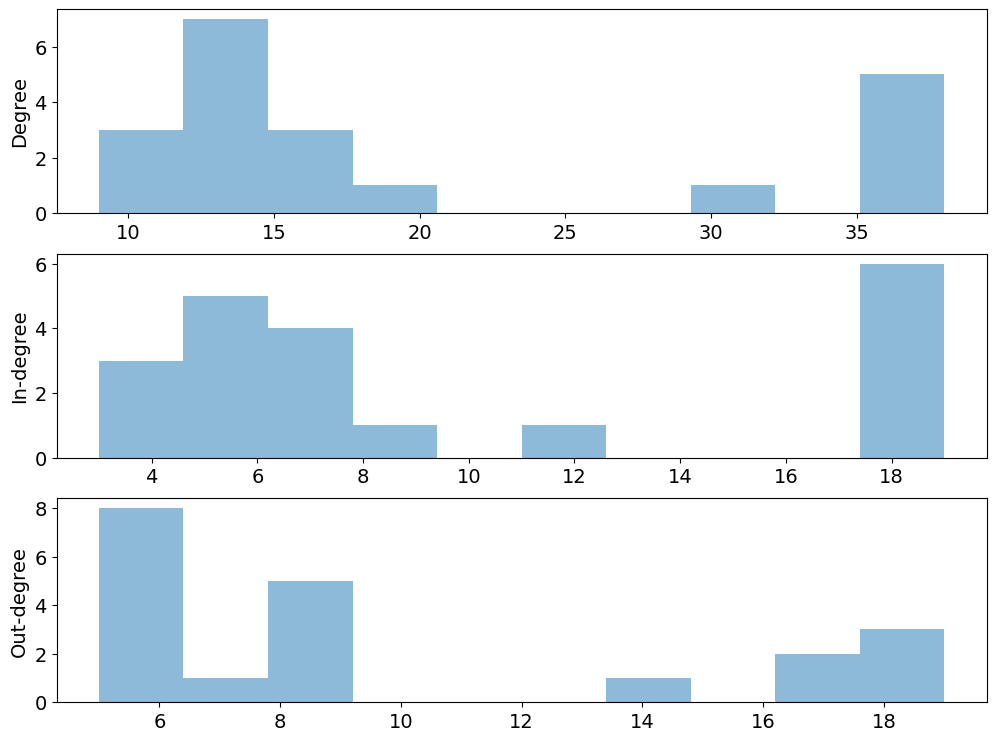

In [77]:
# Compute the in-degree, out-degree and degree of each node. 
# Plot the degree distribution and print the average degree. Print the five most central nodes according to each degree measure? 
degree_values = [v for k, v in G.degree()]
indegree_values = [v for k, v in G.in_degree()]
outdegree_values = [v for k, v in G.out_degree()]

print(np.mean(degree_values))
print(np.mean(indegree_values))
print(np.mean(outdegree_values))

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 3*3))
axs[0].hist(degree_values, alpha=0.5)
axs[0].set_ylabel('Degree', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].hist(indegree_values, alpha=0.5)
axs[1].set_ylabel('In-degree', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

axs[2].hist(outdegree_values, alpha=0.5)
axs[2].set_ylabel('Out-degree', fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=14)

plt.show()

In [78]:
print('Degree:')
print(sorted(G.degree, key=lambda x: x[1], reverse=True)[0:5])
print('In-degree:')
print(sorted(G.in_degree, key=lambda x: x[1], reverse=True)[0:5])
print('Out-degree:')
print(sorted(G.out_degree, key=lambda x: x[1], reverse=True)[0:5])

Degree:
[('participant-1', 38), ('participant-3', 38), ('participant-8', 37), ('participant-6', 36), ('participant-7', 36)]
In-degree:
[('participant-1', 19), ('participant-3', 19), ('participant-6', 19), ('participant-7', 19), ('participant-8', 19)]
Out-degree:
[('participant-1', 19), ('participant-3', 19), ('participant-8', 18), ('participant-6', 17), ('participant-7', 17)]


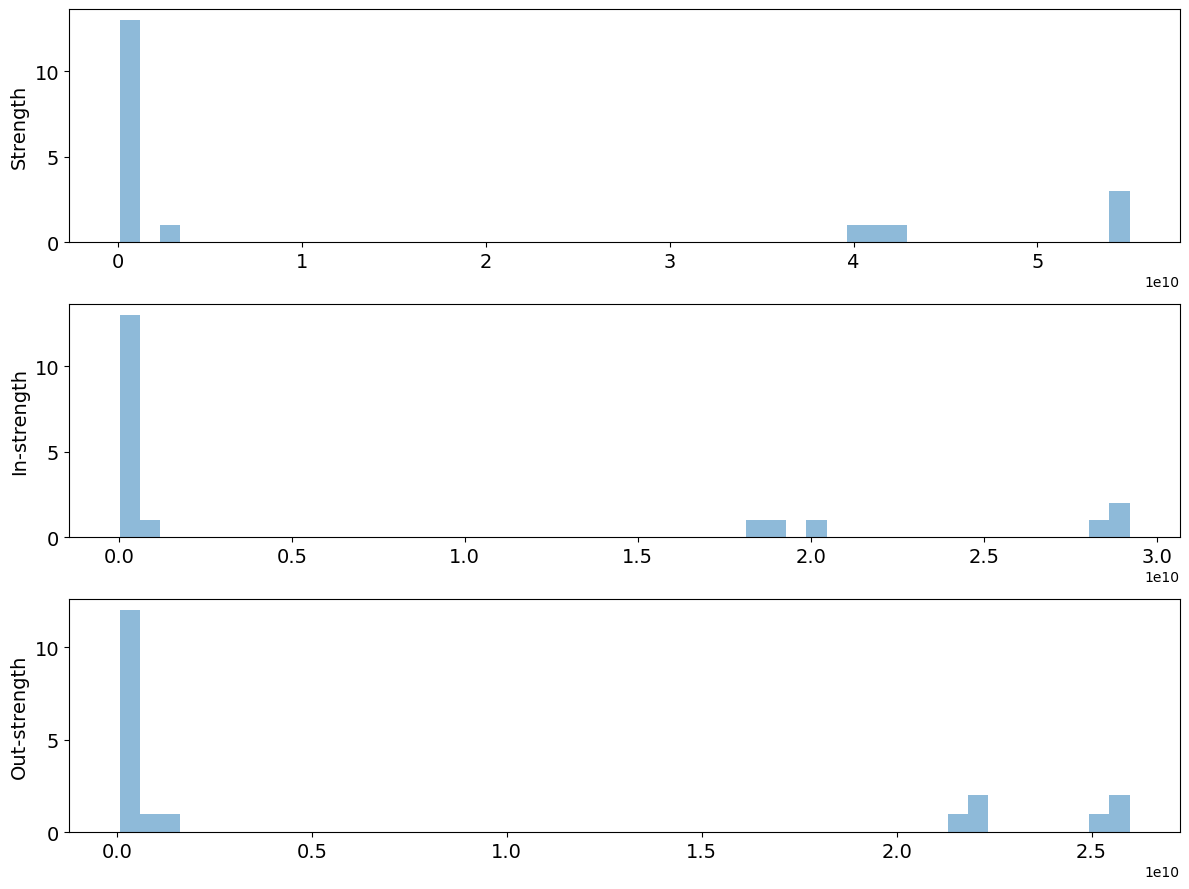

In [79]:
# The strength of a node is defined as its weighted degree. 
# Compute the in- strength, out- strength and strength of each node (weighted by value). 
# Plot the strength distribution and print the average strength. 
# Print the five most central nodes according to each strength measure? What is the meaning of these measures?
strength_values = [v for k, v in G.degree(weight='value')]
instrength_values = [v for k, v in G.in_degree(weight='value')]
outstrength_values = [v for k, v in G.out_degree(weight='value')]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 3*3))
axs[0].hist(strength_values, bins=50, alpha=0.5)
axs[0].set_ylabel('Strength', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].hist(instrength_values, bins=50, alpha=0.5)
axs[1].set_ylabel('In-strength', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)

axs[2].hist(outstrength_values, bins=50, alpha=0.5)
axs[2].set_ylabel('Out-strength', fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

In [80]:
print('Strength:')
print(sorted(G.degree(weight='value'), key=lambda x: x[1], reverse=True)[0:5])
print('In-strength:')
print(sorted(G.in_degree(weight='value'), key=lambda x: x[1], reverse=True)[0:5])
print('Out-strength:')
print(sorted(G.out_degree(weight='value'), key=lambda x: x[1], reverse=True)[0:5])

Strength:
[('participant-6', 55002241630.05944), ('participant-7', 54418038504.52492), ('participant-8', 54018071824.383316), ('participant-1', 41906524244.315735), ('participant-3', 40911799022.253845)]
In-strength:
[('participant-7', 29211725432.061386), ('participant-6', 29085014210.72642), ('participant-8', 28044983284.999), ('participant-1', 19906823266.5265), ('participant-3', 18931349164.745625)]
Out-strength:
[('participant-8', 25973088539.384315), ('participant-6', 25917227419.33302), ('participant-7', 25206313072.463528), ('participant-1', 21999700977.78923), ('participant-3', 21980449857.50822)]


mean: 0.7174955858850545


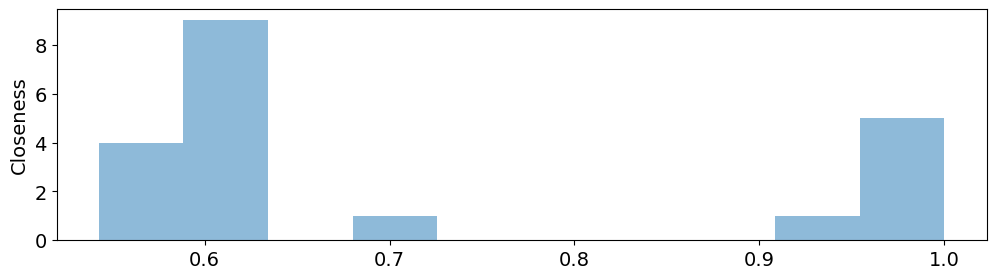

In [81]:
# Compute the closeness centrality of each node. 
# Plot the distribution and print the average closeness centrality. Which node is most central according to the closeness centrality?
closeness_dict = nx.closeness_centrality(G)
closeness_list = list(closeness_dict.values())
print('mean:', np.mean(closeness_list))

fig, ax = plt.subplots(figsize=(12, 3))
ax.hist(closeness_list, alpha=0.5)
ax.set_ylabel('Closeness', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [82]:
df = pd.DataFrame.from_dict(closeness_dict, orient='index').reset_index()
df.rename(columns={'index':'participant', 0:'closeness'}, inplace=True)

In [83]:
df.sort_values('closeness', ascending=False)

,participant,closeness
0,participant-1,1.000000
18,participant-8,1.000000
17,participant-7,1.000000
16,participant-6,1.000000
13,participant-3,1.000000
11,participant-2,0.950000
14,participant-4,0.703704
19,participant-9,0.633333
8,participant-17,0.612903
5,participant-14,0.612903


mean: 0.02631578947368421


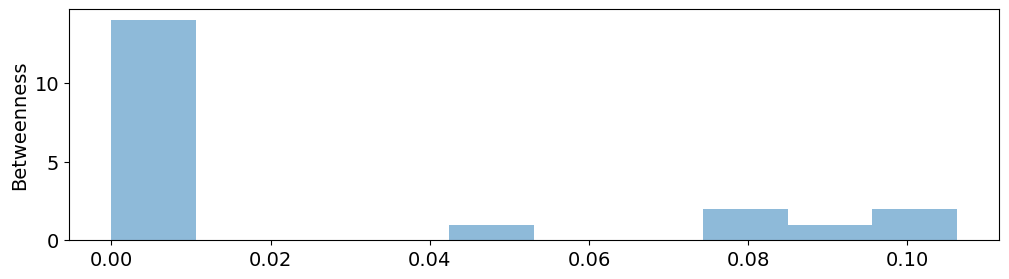

In [84]:
# Compute the betweenness centrality of each node. Plot the distribution and print the average betweenness centrality. 
# Which node is most central according to the betweenness centrality? Is the network robust?
betweenness_dict = nx.betweenness_centrality(G)
betweenness_list = list(betweenness_dict.values())
print('mean:', np.mean(betweenness_list))

fig, ax = plt.subplots(figsize=(12, 3))
ax.hist(betweenness_list, alpha=0.5)
ax.set_ylabel('Betweenness', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [85]:
df = pd.DataFrame.from_dict(betweenness_dict, orient='index').reset_index()
df.rename(columns={'index':'participant', 0:'betweenness'}, inplace=True)

In [86]:
df.sort_values('betweenness', ascending=False)

,participant,betweenness
0,participant-1,0.106196
13,participant-3,0.106196
18,participant-8,0.090602
17,participant-7,0.084266
16,participant-6,0.082414
11,participant-2,0.050028
14,participant-4,0.005291
1,participant-10,0.000905
15,participant-5,0.000418
12,participant-20,0.000000


mean: 0.007368421052631579


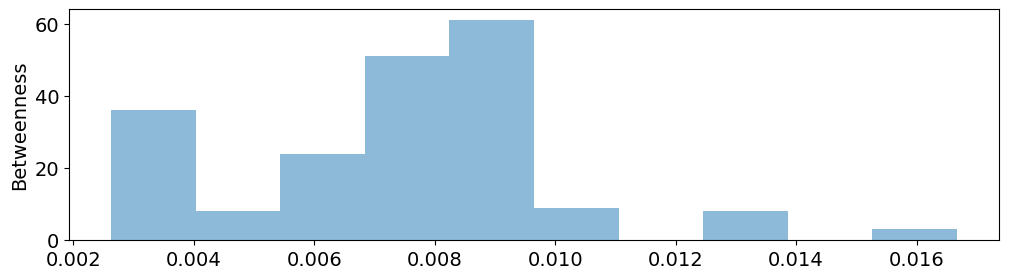

In [87]:
# Compute the betweenness centrality of each edge. Plot the distribution and print the average edge betweenness centrality. 
# Which edge is most central according to the betweenness centrality? Is the network robust?
betweenness_dict = nx.edge_betweenness_centrality(G)
betweenness_list = list(betweenness_dict.values())
print('mean:', np.mean(betweenness_list))

fig, ax = plt.subplots(figsize=(12, 3))
ax.hist(betweenness_list, alpha=0.5)
ax.set_ylabel('Betweenness', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [88]:
df = pd.DataFrame.from_dict(betweenness_dict, orient='index').reset_index()
df.rename(columns={'index':'participant', 0:'betweenness'}, inplace=True)

In [89]:
df.sort_values('betweenness', ascending=False)

,participant,betweenness
114,"(participant-3, participant-18)",0.016667
165,"(participant-7, participant-18)",0.016667
8,"(participant-1, participant-18)",0.016667
181,"(participant-8, participant-15)",0.012500
112,"(participant-3, participant-16)",0.012500
...,...,...
17,"(participant-1, participant-8)",0.002632
105,"(participant-3, participant-1)",0.002632
122,"(participant-3, participant-8)",0.002632
55,"(participant-15, participant-12)",0.002632
